# 1. Introduction

OSIC is a co-operative effort between academia, industry and philanthropy designed to enable rapid advances in the fight against Idiopathic Pulmonary Fibrosis (IPF), fibrosing interstitial lung diseases (ILDs) and other respiratory diseases, including emphysematous conditions. Hence,OSIC hosted a challenge on kaggle platform to predict a patient’s severity of decline in lung function based on a CT(Computerised Tomography) scan of their lungs and metadata of the patients.

# 2. HealthCare Sector Objective
Given image, metadata, and baseline FVC as input, our task is to predict prognosis of Pulmunory Fibrosis i.e the final three FVC measurements for each patient, as well as a confidence value in our prediction. <br>
There is no strict latency constraint and correct confidence of pediction is important. 

# 3. Performance Metrics
Evaluation is done on modified version of the Laplace Log Likelihood. In medical applications, it is useful to evaluate a model's confidence in its decisions. Accordingly, the metric is designed to reflect both the accuracy and certainty of each prediction.
<br>
For each true FVC measurement, you will predict both an FVC and a confidence measure (standard deviation σ). The metric is computed as:<br>
$$\begin{eqnarray} \\
\sigma_{clipped}=max(\sigma,70)\\
\nabla=min(|FVC_{true}−FVC_{predicted}|,1000)\\
metric=-\frac{\sqrt{2}\nabla}{\sigma_{clipped}}- \ln(\sqrt{2}\sigma_{clipped})\\
\end{eqnarray}$$

# 4. Data Overview
**Three csv files and two folders are provided:**

* train.csv - the training set, contains full history of clinical information
* test.csv - the test set, contains only the baseline measurement
* train/ - contains the training patients' baseline CT scan in DICOM format
* test/ - contains the test patients' baseline CT scan in DICOM format
* sample_submission.csv - demonstrates the submission format

**Attributes in train.csv and test.csv:**

* *Patient*- a unique Id for each patient (also the name of the patient's DICOM folder)
* *Weeks*- the relative number of weeks pre/post the baseline CT (may be negative)
* *FVC* - the recorded lung capacity in ml
* *Percent*- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
* *Age*- patient's age
* *Sex*- patient's gender
* *SmokingStatus*- whether a patient somkes or not.

**Attributes in sample submission.csv**
* *Patient_Week* - a unique Id formed by concatenating the Patient and Weeks columns (i.e. ABC_22 is a prediction for patient ABC at week 22)
* *FVC* - the predicted FVC in ml
* *Confidence* - a confidence value of your prediction (also has units of ml)

**Info About FVC**:
Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled. FVC can also help doctors assess the progression of lung disease and evaluate the effectiveness of treatment. <br>

A person who is diagnosed with obstructive lung diseases such as asthma and chronic obstructive pulmonary disease (COPD) has a lower FVC result than a healthy person.Decreases in the FVC value may mean the lung disease is getting worse.

* Average normal values in healthy males aged 20-60 range from 5500 to 4750 mililiters.
* Average normal values for females aged 20-60 range from 3750 to 3250 mililiters.
* Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics. Percentage with normal test values falling between 80% and 120% of the average values.

<br>Refernce : https://www.nuvoair.com/blog/do-you-know-how-to-interpret-the-results-of-your-spirometry-test

## Some useful resources:
https://www.kaggle.com/andradaolteanu/pulmonary-fibrosis-competition-eda-dicom-prep <br>
https://www.kaggle.com/pradyut23/pulmonary-fibrosis-eda/notebook <br>
https://www.kaggle.com/writetoneeraj/fundamentals-of-medical-image-processing

# 5.Exploratory Data Analysis
## 5.1. Analysis of metadata


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pydicom
import os
import cv2
from sklearn.cluster import KMeans
from skimage import measure, morphology

In [2]:
train=pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')
print('Train Data Shape:', train.shape)
print(train.head())

Train Data Shape: (1549, 7)
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker


In [3]:
test=pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')
print('Test Data Shape:', test.shape)
print(test.head())

Test Data Shape: (5, 7)
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked


In [4]:
sub=pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
print('Submission File Shape', sub.shape)
print(sub.head())

Submission File Shape (730, 3)
                    Patient_Week   FVC  Confidence
0  ID00419637202311204720264_-12  2000         100
1  ID00421637202311550012437_-12  2000         100
2  ID00422637202311677017371_-12  2000         100
3  ID00423637202312137826377_-12  2000         100
4  ID00426637202313170790466_-12  2000         100


In [5]:
train.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [6]:
test.describe()

,Weeks,FVC,Percent,Age
count,5.000000,5.000000,5.000000,5.000000
mean,8.800000,2781.600000,75.997702,71.800000
std,7.049823,516.475846,4.970960,2.167948
min,0.000000,1930.000000,70.186855,68.000000
25%,6.000000,2739.000000,71.824968,72.000000
50%,6.000000,2925.000000,76.672493,73.000000
75%,15.000000,3020.000000,79.258903,73.000000
max,17.000000,3294.000000,82.045291,73.000000


In [7]:
#Patient
print('Number of unique patients:',len(train['Patient'].unique()))

Number of unique patients: 176


In [8]:
train['Patient'].value_counts()

ID00105637202208831864134    10
ID00343637202287577133798    10
ID00421637202311550012437    10
ID00167637202237397919352    10
ID00400637202305055099402    10
                             ..
ID00276637202271694539978     7
ID00111637202210956877205     7
ID00052637202186188008618     7
ID00047637202184938901501     6
ID00267637202270790561585     6
Name: Patient, Length: 176, dtype: int64

There are 176 unique patient information given in training data, and each patient's record is included as minimum as 6 times and maximum upto 10 times, since the FVC measurement is done at different week counts.

In [9]:
#Checking missing value
print('Missing value in train data:\n', train.isnull().any())
print('Missing value in test data:\n', test.isnull().any())

Missing value in train data:
 Patient          False
Weeks            False
FVC              False
Percent          False
Age              False
Sex              False
SmokingStatus    False
dtype: bool
Missing value in test data:
 Patient          False
Weeks            False
FVC              False
Percent          False
Age              False
Sex              False
SmokingStatus    False
dtype: bool


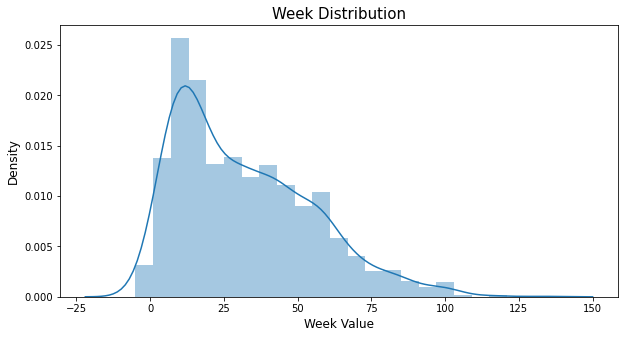

In [10]:
#Week
fig=plt.figure(figsize=(10,5))
sn.distplot(train['Weeks'])
plt.title('Week Distribution',size=15)
plt.xlabel('Week Value',size=12)
plt.ylabel('Density', size=12);

Most patient's FVC value is recorded in between week 1 and week 25. Also, week value can be negative too, which means FVC is measured before baseline CT scan.

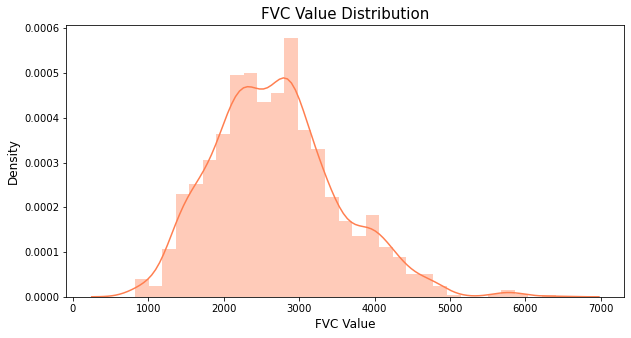

In [11]:
#FVC
fig=plt.figure(figsize=(10,5))
sn.distplot(train['FVC'], color='coral')
plt.title('FVC Value Distribution',size=15)
plt.xlabel('FVC Value',size=12)
plt.ylabel('Density', size=12);

FVC value is measured in ml, most of the patient's have FVC value between 2000ml and 3000ml. And very few patients have FVC more than 5000ml. 

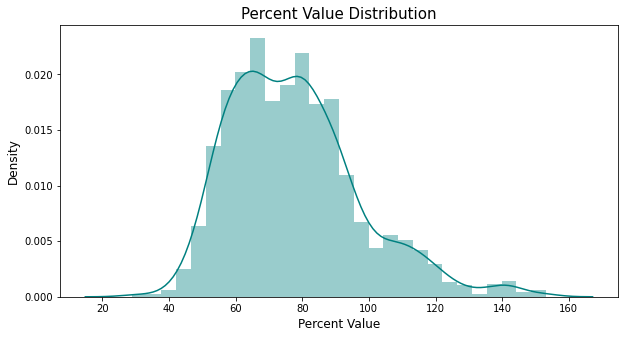

In [12]:
#Percent
fig=plt.figure(figsize=(10,5))
sn.distplot(train['Percent'], color='Teal')
plt.title('Percent Value Distribution',size=15)
plt.xlabel('Percent Value',size=12)
plt.ylabel('Density', size=12);

This Percent column is not the actual depiction os some percentage value.
## Analysing Patient's Age, Sex and Smoking status 

In [13]:
temp = train[['Patient','Age','Sex','SmokingStatus']].drop_duplicates()
temp

,Patient,Age,Sex,SmokingStatus
0,ID00007637202177411956430,79,Male,Ex-smoker
9,ID00009637202177434476278,69,Male,Ex-smoker
18,ID00010637202177584971671,60,Male,Ex-smoker
27,ID00011637202177653955184,72,Male,Ex-smoker
36,ID00012637202177665765362,65,Male,Never smoked
...,...,...,...,...
1504,ID00419637202311204720264,73,Male,Ex-smoker
1513,ID00421637202311550012437,68,Male,Ex-smoker
1523,ID00422637202311677017371,73,Male,Ex-smoker
1531,ID00423637202312137826377,72,Male,Ex-smoker


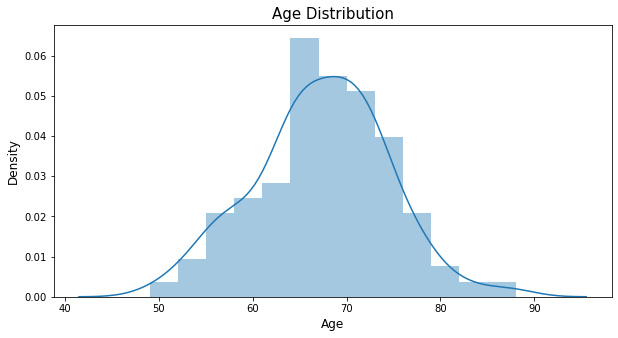

In [14]:
plt.figure(figsize=(10,5))
sn.distplot(temp['Age'],)
plt.title('Age Distribution',size=15)
plt.xlabel('Age',size=12)
plt.ylabel('Density', size=12);

Most Patient's age is approximately in the range of 65 to 75.

In [15]:
print('Minimum age:', temp['Age'].min())
print('Maximum age:', temp['Age'].max())

Minimum age: 49
Maximum age: 88


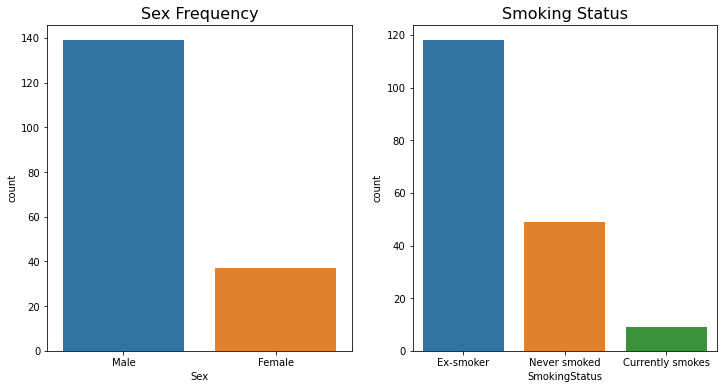

In [16]:
# Figure
f, (ax2, ax3) = plt.subplots(1, 2, figsize = (12, 6))

b = sn.countplot(x = "Sex",data=temp, ax=ax2,)
c = sn.countplot(x = "SmokingStatus",data= temp, ax=ax3,)


b.set_title("Sex Frequency", fontsize=16)
c.set_title("Smoking Status", fontsize=16);

# Dicom Data Analysis
This is my first experience working with dicom data. DICOM stands for Digital Imaging and Communications in Medicine. It is a standard, internationally accepted format to view, store, retrieve and share medical images. DICOM is a format that has metadata, as well as Pixeldata attached to it.Some basic info can be extracted from image metadata: gender and age of the patient, as well as info how the image is sampled and generated.
<br> As there are 176 patient in train data, so corresponding to each patient we have a folder(folder name=Patient id) which contains CT scan in DICOM format.  

In [17]:
train_path = '/kaggle/input/osic-pulmonary-fibrosis-progression/train'
train_dir = os.listdir(train_path)
scan_per_patient = []
for dirc in train_dir:
    scans = len(os.listdir(train_path+'/'+dirc))
    scan_per_patient.append(scans)

In [18]:
train_CT = pd.DataFrame({'Patient_ID':train_dir,'Scans_Per_Patient':scan_per_patient})
train_CT

,Patient_ID,Scans_Per_Patient
0,ID00015637202177877247924,295
1,ID00035637202182204917484,574
2,ID00290637202279304677843,240
3,ID00400637202305055099402,265
4,ID00073637202198167792918,355
...,...,...
171,ID00086637202203494931510,30
172,ID00216637202257988213445,21
173,ID00240637202264138860065,33
174,ID00248637202266698862378,16


In [19]:
print('Minimum number of CT Scans:', train_CT['Scans_Per_Patient'].min())
print('Maximum number of CT Scans:', train_CT['Scans_Per_Patient'].max())
print('Average number of CT Scans:', train_CT['Scans_Per_Patient'].mean())

Minimum number of CT Scans: 12
Maximum number of CT Scans: 1018
Average number of CT Scans: 187.64772727272728


In [20]:
test_path = '/kaggle/input/osic-pulmonary-fibrosis-progression/test'
test_dir = os.listdir(test_path)
scan_per_patient = []
for dirc in test_dir:
    scans = len(os.listdir(test_path+'/'+dirc))
    scan_per_patient.append(scans)

In [21]:
test_CT = pd.DataFrame({'Patient_ID':test_dir,'Scans_Per_Patient':scan_per_patient})
test_CT

,Patient_ID,Scans_Per_Patient
0,ID00419637202311204720264,28
1,ID00421637202311550012437,62
2,ID00422637202311677017371,473
3,ID00423637202312137826377,290
4,ID00426637202313170790466,408


In [22]:
# https://www.kdnuggets.com/2017/03/medical-image-analysis-deep-learning.html
path = '/kaggle/input/osic-pulmonary-fibrosis-progression/'
dicom_files = []  # create an empty list
for dirName, subdirList, fileList in os.walk(path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            dicom_files.append(os.path.join(dirName,filename))


In [23]:
print('There are total {} dicom files given to us'.format(len(dicom_files)))

There are total 34287 dicom files given to us


In [24]:
dicom_files[:5]

['/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/12.dcm',
 '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/18.dcm',
 '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/9.dcm',
 '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/22.dcm',
 '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/25.dcm']

In dicom_files list I have collected all the paths for dicom files given in both train and test set. From each of the dcm file, I will extract certain information from meta data attached with dcm file  and store it in csv files.

In [25]:
def get_metainfo(path):
    '''Get information from the .dcm files.
    path: complete path to the .dcm file'''

    image_data = pydicom.read_file(path)

    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split('/')[6],
        "Rows" : image_data.Rows,
        "Columns" : image_data.Columns,

        "PatientID" : image_data.PatientID,
        "SliceThickness" : int(image_data.SliceThickness),
        "KVP" : int(image_data.KVP),
        "GantryDetectorTilt" : int(image_data.GantryDetectorTilt),
        "TableHeight" : int(image_data.TableHeight),
        "RotationDirection" : image_data.RotationDirection,
        "XRayTubeCurrent" : int(image_data.XRayTubeCurrent),
        "GeneratorPower" : int(image_data.GeneratorPower),
        "FocalSpot" : int(image_data.FocalSpots),
        "ConvolutionKernel" : image_data.ConvolutionKernel,
        "PatientPosition" : image_data.PatientPosition,
        "StudyInstanceUID" : image_data.StudyInstanceUID,
        "SeriesInstanceUID" : image_data.SeriesInstanceUID,
        "InstanceNumber" : int(image_data.InstanceNumber),
        "ImagePositionPatient" : image_data.ImagePositionPatient,
        "ImageOrientationPatient" : image_data.ImageOrientationPatient,
        "FrameOfReferenceUID" : image_data.FrameOfReferenceUID,
        "PositionReferenceIndicator" : image_data.PositionReferenceIndicator,
        "SliceLocation" : int(image_data.SliceLocation),
        "PixelSpacing" : str(image_data.PixelSpacing),
        "ImageType" : str(image_data.ImageType),          
        "PixelPaddingValue" : image_data.PixelPaddingValue,
        "WindowCenter" : int(image_data.WindowCenter),
        "WindowWidth" : int(image_data.WindowWidth),
        "RescaleIntercept" : int(image_data.RescaleIntercept),
        "RescaleSlope" : int(image_data.RescaleSlope)       
       
    }
    
    return observation_data

In [26]:
from tqdm import tqdm

meta_data = []
for path in tqdm(dicom_files):
    try:
        meta_data.append(get_metainfo(path))
    except:
        continue

100%|██████████| 34287/34287 [10:55<00:00, 52.31it/s]


In [27]:
#storing meta data to csv file

meta_info = pd.DataFrame.from_dict(meta_data)
print(meta_info.shape)
meta_info.head()

(5450, 29)


,FileNumber,Rows,Columns,PatientID,SliceThickness,KVP,GantryDetectorTilt,TableHeight,RotationDirection,XRayTubeCurrent,...,FrameOfReferenceUID,PositionReferenceIndicator,SliceLocation,PixelSpacing,ImageType,PixelPaddingValue,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope
0,12.dcm,1100,888,ID00419637202311204720264,1,120,0,197,CW,301,...,2.25.87733149435852076944786005695371983233,SN,-74,"[0.820312, 0.820312]","['ORIGINAL', 'PRIMARY', 'AXIAL']",63536,-500,-1500,0,1
1,18.dcm,1100,888,ID00419637202311204720264,1,120,0,197,CW,288,...,2.25.87733149435852076944786005695371983233,SN,-134,"[0.820312, 0.820312]","['ORIGINAL', 'PRIMARY', 'AXIAL']",63536,-500,-1500,0,1
2,9.dcm,1100,888,ID00419637202311204720264,1,120,0,197,CW,301,...,2.25.87733149435852076944786005695371983233,SN,-44,"[0.820312, 0.820312]","['ORIGINAL', 'PRIMARY', 'AXIAL']",63536,-500,-1500,0,1
3,22.dcm,1100,888,ID00419637202311204720264,1,120,0,197,CW,275,...,2.25.87733149435852076944786005695371983233,SN,-174,"[0.820312, 0.820312]","['ORIGINAL', 'PRIMARY', 'AXIAL']",63536,-500,-1500,0,1
4,25.dcm,1100,888,ID00419637202311204720264,1,120,0,197,CW,301,...,2.25.87733149435852076944786005695371983233,SN,-204,"[0.820312, 0.820312]","['ORIGINAL', 'PRIMARY', 'AXIAL']",63536,-500,-1500,0,1


In [28]:
meta_info.DistanceSourceToDetector.unique()

AttributeError: 'DataFrame' object has no attribute 'DistanceSourceToDetector'

## Conversion to Hounsfield Units

The Hounsfield scale is a quantitative scale for describing radiodensity in medical CT scan and provides an accurate density for the type of tissue. Plain x-rays which only displays 5 densities (i.e. air/fat/soft tissue/bone/metal), CT displays a huge range of densities ranging from air (black) to bone (white). On the Hounsfield scale, water represented by 0 value, air is represented by a value of −1000 (black on the grey scale) and bone between +700 (cancellous bone) to +3000 (dense bone) (white on the grey scale). As bones are much denser than surrounding soft tissues, they show up very clearly in CT images. Raw pixel values of images gets convereted into Hounsfield Units because the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable. 

In [29]:
def load_slices(path):
    '''
    This function is used to sort all the slices of CT scan of each 
    patient in decreasing order based on InstanceNumber
    '''
    filenames = os.listdir(path)
    slices = [pydicom.dcmread(f'{path}/{file}') for file in filenames]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
    return slices

In [30]:
def get_pixels_hu(slices):
    """
    Converts raw images to Hounsfield Units (HU).
    
    Parameters: scans (Raw images)
    
    Returns: image (NumPy array)
    """
    
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    # Since the scanning equipment is cylindrical in nature and image output is square,
    # we set the out-of-scan pixels to 0
    image[image == -2000] = 0
    
    
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

## Histogram Analysis

Text(0.5, 1.0, 'HU unit distributions for some scans')

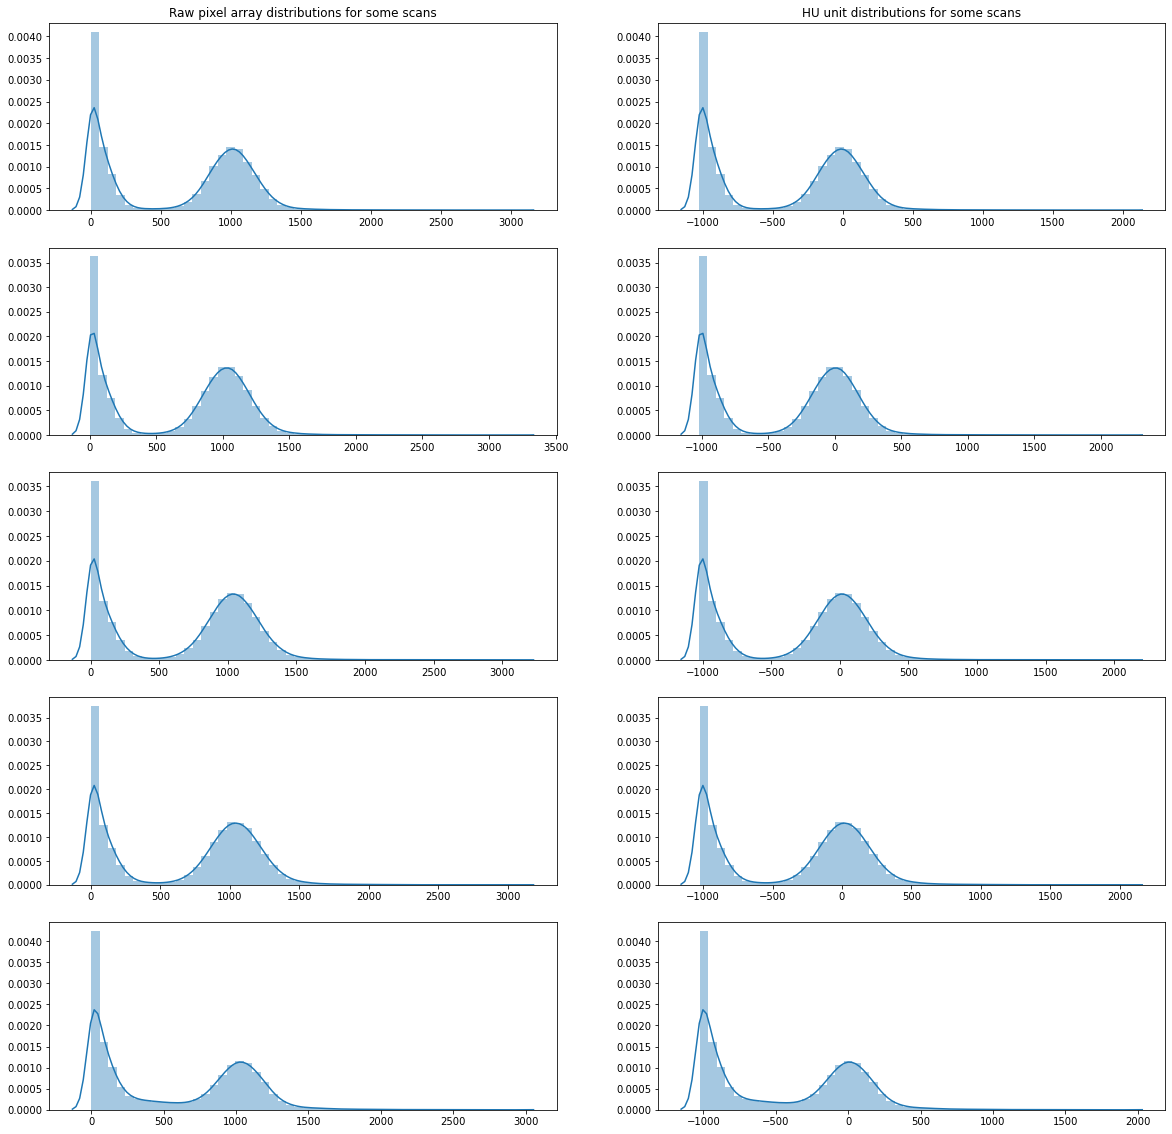

In [31]:
fig,ax = plt.subplots(5,2,figsize=(20,20))
example = train.loc[22]['Patient']
scans = load_slices(f'{train_path}/{example}')
rescaled_images=get_pixels_hu(scans)
images = [scan.pixel_array for scan in scans]
for i in range(5):
    for j in range(1):
        sn.distplot(images[i*10].flatten(), ax=ax[i,j])
        sn.distplot(rescaled_images[i*10].flatten(), ax=ax[i, j+1])
ax[0,0].set_title("Raw pixel array distributions for some scans")
ax[0,1].set_title("HU unit distributions for some scans")

## Segmentation
Segmentation is most important part of medical image processing as it extracts region of interest. Segmentation defines narrowly what algorithm want to look at, so definitely CNN will perform better on segmented images rather than on whole chest image. Segmentation is done by many ways and clustering is most common among all. Clustering has several techniques such as K-means clustering, hierarchical clustering, divisive clustering, and mean shift clustering. Moreover, due to the irregular and fuzzy borders in most of the medical images, fuzzy set and neutrosophic set theories become important in the segmentation process to handle uncertainty in the medical images. Read more about medical image segmentation [here](https://www.sciencedirect.com/topics/engineering/medical-image-segmentation). After clustering images are morphed using erosion(contraction) and dialation(expansion) to remove unwanted border areas and label different reasons separately. So the steps goes as:

1. Normalization of image.
2. Clustering for separating lung with everything else.
3. Threshold image.
4. Morphology - Erosion followed by dialation.
5. Label different regions and define regions with different colors.
6. Create lung mask.
7. Apply mask on original image and get final masked image.

In [32]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    
    # Threshold the image and the output will be a binary image. Morphology workes either on binary or gray images.
    thresh_img = np.where(img<threshold,1.0,0.0)
    
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img


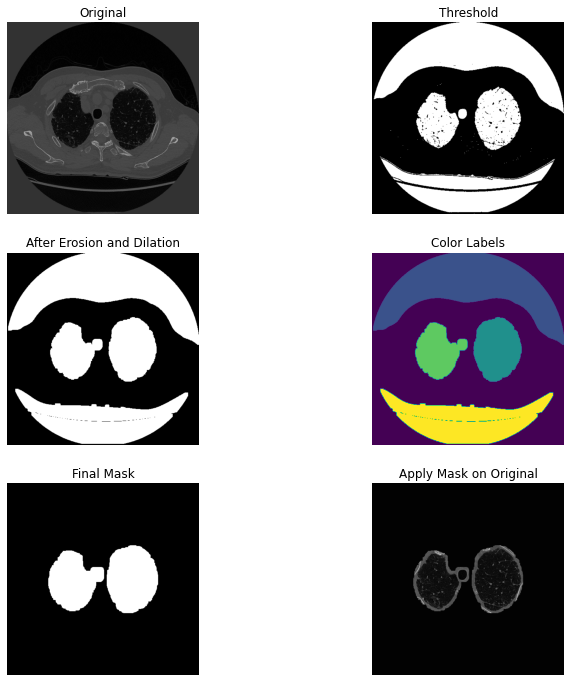

In [33]:
image = pydicom.dcmread(dicom_files[111]).pixel_array
mask = make_lungmask(image,display=True)